<a href="https://colab.research.google.com/github/dogukartal/IBM_AI_Labs/blob/main/Deep%20Learning%20with%20Keras%20and%20Tensorflow/Transformers%20in%20Keras/Implementing_Transformers_for_Text_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import get_file

In [ ]:
# Load the dataset
path_to_file = get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

# Preview the dataset
print(text[464:1000])

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.




In [ ]:
# Preprocess the dataset
vocab_size = 10000
seq_length = 100

# Adapt TextVectorization to full text
vectorizer = TextVectorization(max_tokens=vocab_size, output_mode='int')
text_ds = tf.data.Dataset.from_tensor_slices([text]).batch(1)
vectorizer.adapt(text_ds)

# Vectorize the text
vectorized_text = vectorizer([text])[0]
print("Vectorized text shape:", vectorized_text.shape)
print("First 10 vectorized tokens:", vectorized_text.numpy()[:10])

Vectorized text shape: (202646,)
First 10 vectorized tokens: [ 89 270 138  36 982 144 673 125  16 106]


In [ ]:
def create_sequences(text, seq_length):
    input_seqs = []
    target_seqs = []
    for i in range(len(text) - seq_length):
        input_seq = text[i:i + seq_length]
        target_seq = text[i + 1:i + seq_length + 1]
        input_seqs.append(input_seq)
        target_seqs.append(target_seq)
    return np.array(input_seqs), np.array(target_seqs)

# Generate sequences
X, Y = create_sequences(vectorized_text.numpy(), seq_length)

# Check if sequences are correctly generated
print("Number of sequences generated:", len(X))
print("Sample input sequence:", X[0] if len(X) > 0 else "No sequences generated")

# Check if X and Y are not empty
assert X.size > 0, "Input data X is empty"
assert Y.size > 0, "Target data Y is empty"
X = tf.convert_to_tensor(X)
Y = tf.convert_to_tensor(Y)
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)


Number of sequences generated: 202546
Sample input sequence: [  89  270  138   36  982  144  673  125   16  106   34  106  106   89
  270    7   41   34 1286  344    4  200   64    4 3690   34 1286 1286
   89  270   89    7   93 1187  225   12 2442  592    4    2  307   34
   36 2655   36 2655   89  270   72   79  506   27    3   56   24 1390
   57   40  161 2328  644    9 4980   34   32   54 2863  885   72   17
   18  163  146  146  165  270   74  218   46  595   89  270   36   41
 6739  172  595    2 1780   46   29 1323 5151   47   58 4151   79   39
   60   58]
Shape of X: (202546, 100)
Shape of Y: (202546, 100)


In [ ]:
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Model

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TransformerModel(Model):  # Model is now properly imported
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length):
        super(TransformerModel, self).__init__()
        self.embedding = Embedding(vocab_size, embed_dim)
        self.pos_encoding = self.positional_encoding(seq_length, embed_dim)
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)]
        self.dense = Dense(vocab_size)

    def positional_encoding(self, seq_length, embed_dim):
        angle_rads = self.get_angles(np.arange(seq_length)[:, np.newaxis], np.arange(embed_dim)[np.newaxis, :], embed_dim)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, embed_dim):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
        return pos * angle_rates

    def call(self, inputs, training=False):
        seq_len = tf.shape(inputs)[1]
        x = self.embedding(inputs)
        x += self.pos_encoding[:, :seq_len, :]
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)  # Pass training argument correctly
        output = self.dense(x)
        return output

In [ ]:
# Hyperparameters
embed_dim = 256
num_heads = 4
ff_dim = 512
num_layers = 4

# Build the Transformer model
model = TransformerModel(vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length)

# Provide input shape to build the model by passing a dummy input with maxval specified
_ = model(tf.random.uniform((1, seq_length), maxval=vocab_size, dtype=tf.int32))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Summary of the model
model.summary()

Model: "transformer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (1, 100, 256)               │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ ?                           │       1,315,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_1                  │ ?                           │       1,315,840 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_2                  │ ?                           │       1,315,840 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_3                  │ ?                           │       1,315,840 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (1, 100, 10000)             │       2,570,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,393,360 (39.65 MB)

 Trainable params: 10,393,360 (39.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
6330/6330 ━━━━━━━━━━━━━━━━━━━━ 147s 15ms/step - loss: 11.9143
Epoch 2/20
6330/6330 ━━━━━━━━━━━━━━━━━━━━ 63s 10ms/step - loss: 12.0208
Epoch 3/20
6330/6330 ━━━━━━━━━━━━━━━━━━━━ 60s 10ms/step - loss: 11.1338
Epoch 4/20
6330/6330 ━━━━━━━━━━━━━━━━━━━━ 61s 10ms/step - loss: 10.7668
Epoch 5/20
6330/6330 ━━━━━━━━━━━━━━━━━━━━ 62s 10ms/step - loss: 10.6264
Epoch 6/20
6330/6330 ━━━━━━━━━━━━━━━━━━━━ 60s 10ms/step - loss: 10.6155
Epoch 7/20
6330/6330 ━━━━━━━━━━━━━━━━━━━━ 61s 10ms/step - loss: 10.4728
Epoch 8/20
6330/6330 ━━━━━━━━━━━━━━━━━━━━ 62s 10ms/step - loss: 10.4664
Epoch 9/20
6330/6330 ━━━━━━━━━━━━━━━━━━━━ 63s 10ms/step - loss: 10.5873


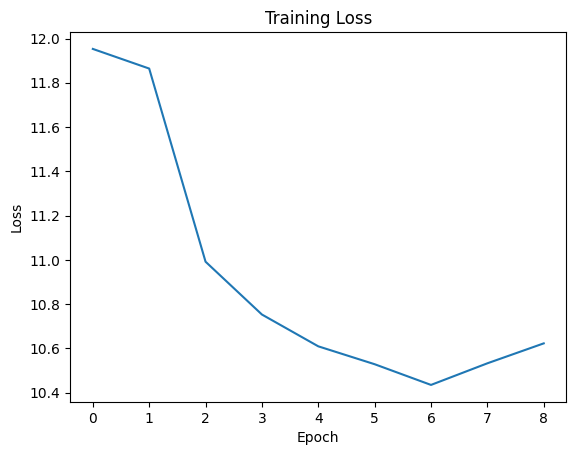

In [ ]:
# Import necessary libraries for training visualization
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback to stop training if the loss doesn't improve
early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

# Train the transformer model on the full input and target sequences
history = model.fit(X, Y, epochs=20, batch_size=32, callbacks=[early_stopping])

# Plot training loss to monitor model performance over epochs
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
def generate_text(model, start_string, num_generate=100, temperature=1.0):
    # Convert the start string to a vectorized format
    input_eval = vectorizer([start_string]).numpy()

    # Ensure the input length is the same as the model's expected input shape
    if input_eval.shape[1] < seq_length:
        # Pad the input if it's shorter than the expected sequence length
        padding = np.zeros((1, seq_length - input_eval.shape[1]))
        input_eval = np.concatenate((padding, input_eval), axis=1)
    elif input_eval.shape[1] > seq_length:
        # Truncate the input if it's longer than the expected sequence length
        input_eval = input_eval[:, -seq_length:]

    input_eval = tf.convert_to_tensor(input_eval)

    # Initialize an empty list to store generated text
    text_generated = []

    # Start generating text
    for i in range(num_generate):
        # Make predictions using the model
        predictions = model(input_eval)

        # Get the prediction for the last timestep only (the next word)
        predictions = predictions[:, -1, :]  # This should be of shape [1, vocab_size]

        # Apply temperature to predictions
        predictions = predictions / temperature

        # Use a categorical distribution to predict the next word
        predicted_id = tf.random.categorical(predictions, num_samples=1)[0, 0].numpy()

        # Update the input tensor to include the predicted word, maintaining the sequence length
        input_eval = np.append(input_eval.numpy(), [[predicted_id]], axis=1)  # Append predicted token
        input_eval = input_eval[:, -seq_length:]  # Keep only the last `seq_length` tokens
        input_eval = tf.convert_to_tensor(input_eval)  # Convert back to tensor

        # Append the predicted word to the generated text
        text_generated.append(vectorizer.get_vocabulary()[predicted_id])

    # Return the generated text starting from the initial seed
    return start_string + ' ' + ' '.join(text_generated)

In [ ]:
# Generate text with temperature control
start_string = "To be, or not to be"
generated_text = generate_text(model, start_string, temperature=0.7)  # Lower temperature for more focused predictions
print(generated_text)

To be, or not to be bianca diet summond headstrong feign beard straind trial diggd fourteen blame creature pupillike disloyal them myrtle sear effect retires shrillvoiced split mallows outlive thoroughly tongues saw tutus labouring proceeders confounds serve theekeep print swiftness lodowick revolts lids losing nought lookers moreover hidden bow sup usurer lasting rails twist airy surrender perdurably westward revolting knavery hortensio stirrup safe whiteliverd amends town serve tapestry mouse seven accuse censure cleomenes athwart prop opposition tails dog breton quaintly eve torment fling cup grumbling staind thralld render mixture sincerely thrush sailors up wooes draws innocence naming seconds guard wished contents sued reserved now prioress complaints


In [ ]:
# Define a learning rate scheduler
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr = lr * 0.5
    return lr

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Train the model with the learning rate scheduler
history = model.fit(X, Y, epochs=20, batch_size=64, callbacks=[callback])